# Final_Project_PAC2021

소프트웨어융합학과 2018102111 서보민

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import scipy

In [2]:
df = pd.read_csv("IXI_train.csv")
df = df.dropna(axis=0)

# ICV와 피질두께는 독립적
대뇌 피질을 구성하는 회백질의 부피는 해당 영역의 표면적과두께의 곱으로 구성되는데 표면적은 유전적 성향과 연관된뇌의 접힘 양상 등에 따라 다양한 편차가 있어 피질 두께와부피 사이의 관계가 항상 일정하지 않아 피질 두께 연구 결과들은 부피 연구 결과들과 독립적인 양상을 보인다
https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002026794

# 뇌의 부피도 나이에 따라 변화
미국 국립노화 연구소의 래포트 박사에 의하면 실제 뇌의 부피가 20-70세사이에 평균 10%, 일년에 0.2% 정도가 감소하 는 것은 사실이지만 그 정도의 신경세포 감소로는 지적기능이 크게 떨어지거나 노인성 치매에 걸릴 가능 성이 높아지지는 않는다고 한다

데이터를 어떻게 사용해야할지 많은 고민을 했고 다음과 같은 방법은 사용했습니다.

1. 모든 데이터를 training data로 사용
2. cross_var_predict로 예측값을 저장한 후 실제값과 차이가 큰 경우 삭제
-------------------------------------------------------------------------
위의 자료를 읽고 시간에 따른 뇌 부피의 기록이 아닌 현재의 뇌 부피의 데이터만 가지고 있기에
뇌의 부피가 나이 예측에 미치는 영향은 적을 것이라고 판단했습니다.

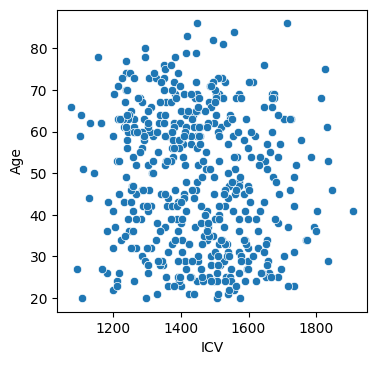

In [3]:
import seaborn as sns
plt.figure(figsize = (4, 4), dpi = 100)
sns.scatterplot(data = df, x = "ICV", y = "Age");

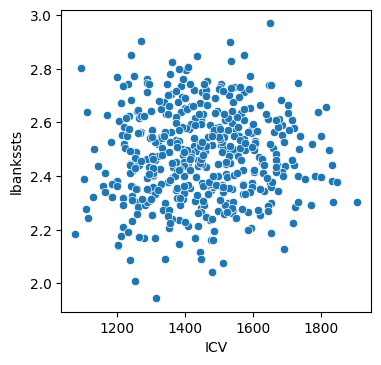

In [4]:
plt.figure(figsize = (4, 4), dpi = 100)
sns.scatterplot(data = df, x = "ICV", y = "lbankssts");

나이와 ICV의 관계 / ICV와 대뇌피질의 관계의 분포를 보고 다음과 같은 방법을 시도했습니다.

1. ICV 제외
2. 전체 데이터를 ICV로 나누어 동일한 부피로 가정 후 training
3. ICV로 대뇌 피질 두께 데이터만 나눈 후 ICV도 가중치를 곱하여 training
4. 뇌를 완전한 구로 가정하여 역산 후 뇌의 반지름을 구한 후 대뇌 피질 두께를 반지름으로 나눈 데이터    를 training

결과적으로 ICV를 제외한 데이터가 정확도가 가장 높았기에 1번의 방법을 선택했습니다.

train set과 validation set의 정확도를 그리는 그래프는 수업 자료를 참고하였으며 회귀 모델의 정보는 https://scikit-learn.org/stable/ 공식 사이트의 내용을 참고하였습니다.

In [5]:
man = df[df['Sex'].values == 1]
y_man = man.Age
X_man = man.drop(['ID', 'Age','Sex','ICV'], axis = 1)

woman = df[df['Sex'].values == 2]
y_woman = woman.Age
X_woman = woman.drop(['ID', 'Age','Sex','ICV'], axis = 1)

In [6]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
x_man = std.fit_transform(X_man)
x_woman = std.fit_transform(X_woman)

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
x_man_train, x_man_valid, y_man_train, y_man_valid = \
        train_test_split(x_man, y_man, test_size=0.1, shuffle=True, random_state=123)

x_woman_train, x_woman_valid, y_woman_train, y_woman_valid = \
        train_test_split(x_woman, y_woman, test_size=0.1, shuffle=True, random_state=123)

# Lasso - Man

In [8]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, RepeatedKFold

reg = linear_model.Lasso(max_iter = 10000, random_state = 1)
param_grid = {'alpha' : np.arange(0.01,1,0.01)}
grid = GridSearchCV(reg, param_grid = param_grid, 
                    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state = 123),
                    return_train_score=True)
grid.fit(x_man_train,y_man_train)
print(f"best parameters: {grid.best_params_}")
print(f"valid-set score: {grid.score(x_man_valid, y_man_valid):.3f}")

best parameters: {'alpha': 0.33}
valid-set score: 0.775


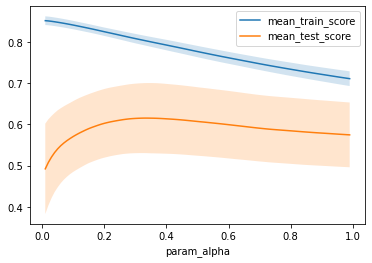

In [9]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

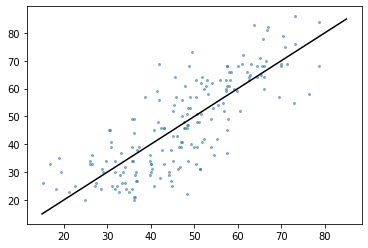

In [10]:
from sklearn.model_selection import cross_val_predict

reg = linear_model.Lasso(max_iter = 10000, random_state = 1, alpha = 0.33)
y_man_pred = cross_val_predict(reg, x_man_train, y_man_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_man_pred, y_man_train, alpha=.5, s=4)

# Lasso - Woman

In [11]:
reg = linear_model.Lasso(max_iter = 10000, random_state = 1)
param_grid = {'alpha' : np.arange(0.01,1,0.01)}
grid = GridSearchCV(reg, param_grid = param_grid, 
                    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state = 123), 
                    return_train_score=True)
grid.fit(x_woman_train,y_woman_train)
print(f"best parameters: {grid.best_params_}")
print(f"valid-set score: {grid.score(x_woman_valid, y_woman_valid):.3f}")

best parameters: {'alpha': 0.26}
valid-set score: 0.573


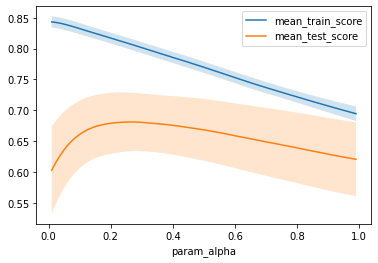

In [12]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

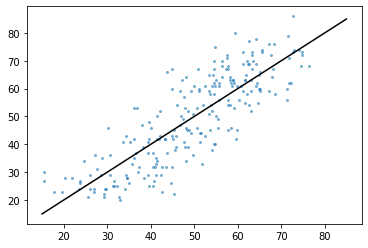

In [13]:
reg = linear_model.Lasso(max_iter = 10000, random_state = 1, alpha = 0.26)
y_woman_pred = cross_val_predict(reg, x_woman_train, y_woman_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_woman_pred, y_woman_train, alpha=.5, s=4)

# Ridge - Man

In [14]:
reg = linear_model.Ridge(max_iter = 10000)
param_grid = {'alpha' : np.arange(50,60,0.1)}
grid2 = GridSearchCV(reg, param_grid = param_grid,
                     cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state = 123),
                     return_train_score=True)
grid2.fit(x_man_train,y_man_train)
print(f"best parameters: {grid2.best_params_}")
print(f"valid-set score: {grid2.score(x_man_valid, y_man_valid):.3f}")

best parameters: {'alpha': 56.30000000000009}
valid-set score: 0.772


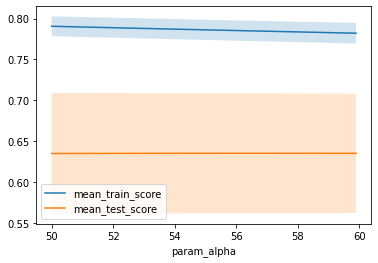

In [15]:
results = pd.DataFrame(grid2.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

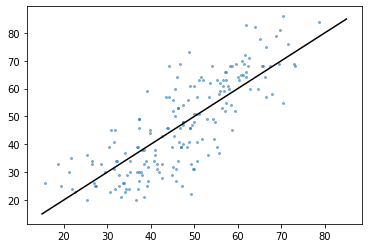

In [16]:
reg = linear_model.Ridge(alpha = 56.3)
y_man_pred = cross_val_predict(reg, x_man_train, y_man_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_man_pred, y_man_train, alpha=.5, s=4)

# Ridge - Woman

In [17]:
reg = linear_model.Ridge()
param_grid = {'alpha' : np.arange(40,50,0.01)}
grid = GridSearchCV(reg, param_grid = param_grid, 
                    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state = 123), 
                    return_train_score=True)
grid.fit(x_woman_train,y_woman_train)
print(f"best parameters: {grid.best_params_}")
print(f"valid-set score: {grid.score(x_woman_valid, y_woman_valid):.3f}")

best parameters: {'alpha': 46.36999999999873}
valid-set score: 0.552


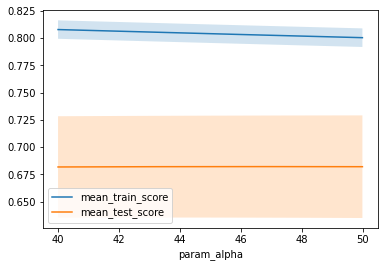

In [18]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

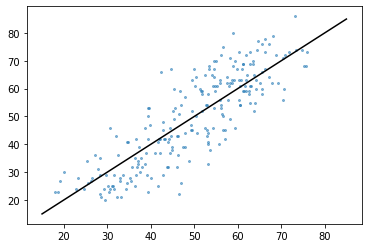

In [19]:
reg = linear_model.Ridge(alpha = 46.3)
y_woman_pred = cross_val_predict(reg, x_woman_train, y_woman_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_woman_pred, y_woman_train, alpha=.5, s=4)

# svm - Man

In [20]:
from sklearn import svm

reg = svm.SVR()
param_grid = { 'C': np.arange(10,20,0.1)}
grid3 = GridSearchCV(reg, param_grid = param_grid,
                     cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state = 123),
                     return_train_score=True)
grid3.fit(x_man_train,y_man_train)
print(f"best parameters: {grid3.best_params_}")
print(f"valid-set score: {grid3.score(x_man_valid, y_man_valid):.3f}")

best parameters: {'C': 15.999999999999979}
valid-set score: 0.587


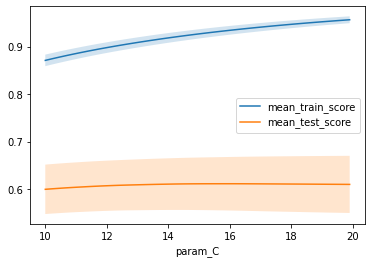

In [21]:
results = pd.DataFrame(grid3.cv_results_)
results.plot('param_C', 'mean_train_score')
results.plot('param_C', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_C.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_C.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

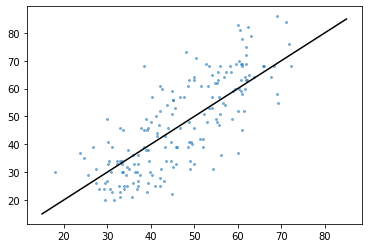

In [22]:
reg = svm.SVR(C = 16.0)
y_man_pred = cross_val_predict(reg, x_man_train, y_man_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_man_pred, y_man_train, alpha=.5, s=4)

# svm - Woman

In [23]:
reg = svm.SVR()
param_grid3 = { 'C': np.arange(20,25,0.1)}
grid3 = GridSearchCV(reg, param_grid = param_grid3,
                     cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state = 123), 
                     return_train_score=True)
grid3.fit(x_woman_train,y_woman_train)
print(f"best parameters: {grid3.best_params_}")
print(f"valid-set score: {grid3.score(x_woman_valid, y_woman_valid):.3f}")

best parameters: {'C': 21.700000000000024}
valid-set score: 0.620


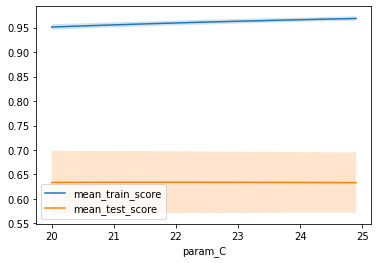

In [24]:
results = pd.DataFrame(grid3.cv_results_)
results.plot('param_C', 'mean_train_score')
results.plot('param_C', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_C.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_C.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

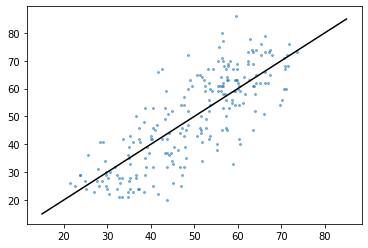

In [25]:
reg = svm.SVR(C = 21.7)
y_woman_pred = cross_val_predict(reg, x_woman_train, y_woman_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_woman_pred, y_woman_train, alpha=.5, s=4)

# KNeighborsRegressor - Man

In [26]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor()
param_grid4 = { 'n_neighbors': np.arange(1,50,2)}
grid4 = GridSearchCV(neigh, param_grid = param_grid4, 
                     cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state = 123), 
                     return_train_score=True)
grid4.fit(x_man_train,y_man_train)
print(f"best parameters: {grid4.best_params_}")
print(f"valid-set score: {grid4.score(x_man_valid, y_man_valid):.3f}")

best parameters: {'n_neighbors': 9}
valid-set score: 0.622


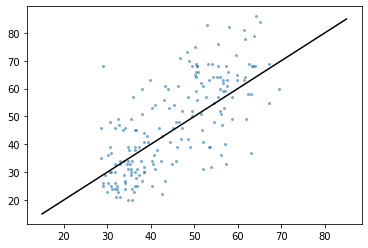

In [27]:
neigh = KNeighborsRegressor(n_neighbors = 9)
y_woman_pred = cross_val_predict(neigh, x_man_train, y_man_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_woman_pred, y_man_train, alpha=.5, s=4)

# KNeighborsRegressor - Woman

In [28]:
neigh = KNeighborsRegressor()
param_grid4 = { 'n_neighbors': np.arange(1,50,2)}
grid4 = GridSearchCV(neigh, param_grid = param_grid4,
                     cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state = 123), 
                     return_train_score=True)
grid4.fit(x_woman_train,y_woman_train)
print(f"best parameters: {grid4.best_params_}")
print(f"valid-set score: {grid4.score(x_woman_valid, y_woman_valid):.3f}")

best parameters: {'n_neighbors': 7}
valid-set score: 0.623


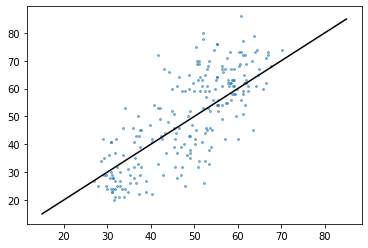

In [29]:
neigh = KNeighborsRegressor(n_neighbors=7)
y_woman_pred = cross_val_predict(neigh, x_woman_train, y_woman_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_woman_pred, y_woman_train, alpha=.5, s=4)

# SGDRegressor - Man

In [30]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(max_iter=1000, tol=1e-3)
param_grid5 = {'alpha' : np.arange(0.1,10,0.1), 'l1_ratio' : np.arange(0.1,1,0.1)}
grid5 = GridSearchCV(sgd, param_grid = param_grid5, 
                     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state = 123), 
                     return_train_score=True)
grid5.fit(x_man_train,y_man_train)
print(f"best parameters: {grid5.best_params_}")
print(f"valid-set score: {grid5.score(x_man_valid, y_man_valid):.3f}")

best parameters: {'alpha': 0.6, 'l1_ratio': 0.4}
valid-set score: 0.751


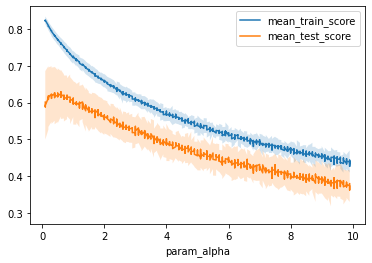

In [31]:
results = pd.DataFrame(grid5.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

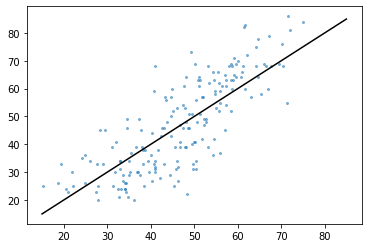

In [68]:
sgd = SGDRegressor(max_iter=1000, tol=1e-3, alpha = 0.6, l1_ratio = 0.4)
y_man_pred = cross_val_predict(sgd, x_man_train, y_man_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_man_pred, y_man_train, alpha=.5, s=4)

# SGDRegressor - Woman

In [33]:
sgd = SGDRegressor(max_iter=1000, tol=1e-3)
param_grid5 = {'alpha' : np.arange(0.1,10,0.1), 'l1_ratio' : np.arange(0.1,1,0.1)}
grid5 = GridSearchCV(sgd, param_grid = param_grid5, 
                     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state = 123), 
                     return_train_score=True)
grid5.fit(x_woman_train,y_woman_train)
print(f"best parameters: {grid5.best_params_}")
print(f"valid-set score: {grid5.score(x_woman_valid, y_woman_valid):.3f}")

best parameters: {'alpha': 0.30000000000000004, 'l1_ratio': 0.2}
valid-set score: 0.552


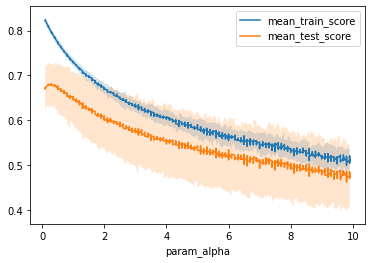

In [34]:
results = pd.DataFrame(grid5.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

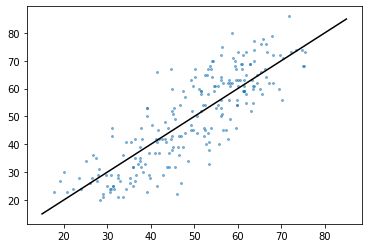

In [35]:
sgd = SGDRegressor(max_iter=1000, tol=1e-3, alpha = 0.3, l1_ratio = 0.2)
y_woman_pred = cross_val_predict(sgd, x_woman_train, y_woman_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_woman_pred, y_woman_train, alpha=.5, s=4)

# TweedieRegressor - Man

In [36]:
from sklearn.linear_model import TweedieRegressor

reg = TweedieRegressor(power=1, link='log')
param_grid5 = {'alpha' : np.arange(10,20,0.1)}
grid5 = GridSearchCV(reg, param_grid = param_grid5, 
                     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state = 123), 
                     return_train_score=True)
grid5.fit(x_man_train,y_man_train)
print(f"best parameters: {grid5.best_params_}")
print(f"valid-set score: {grid5.score(x_man_valid, y_man_valid):.3f}")

best parameters: {'alpha': 19.899999999999963}
valid-set score: 0.712


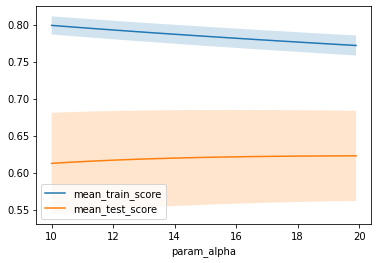

In [37]:
results = pd.DataFrame(grid5.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

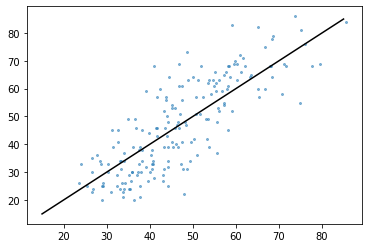

In [38]:
reg = TweedieRegressor(power=1, link='log', alpha = 19.9)
y_man_pred = cross_val_predict(reg, x_man_train, y_man_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_man_pred, y_man_train, alpha=.5, s=4)

# TweedieRegressor - Woman

In [39]:
reg = TweedieRegressor(power=1, link='log')
param_grid5 = {'alpha' : np.arange(10,20,0.1)}
grid5 = GridSearchCV(reg, param_grid = param_grid5, 
                     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state = 123), 
                     return_train_score=True)
grid5.fit(x_woman_train,y_woman_train)
print(f"best parameters: {grid5.best_params_}")
print(f"valid-set score: {grid5.score(x_woman_valid, y_woman_valid):.3f}")

best parameters: {'alpha': 13.399999999999988}
valid-set score: 0.514


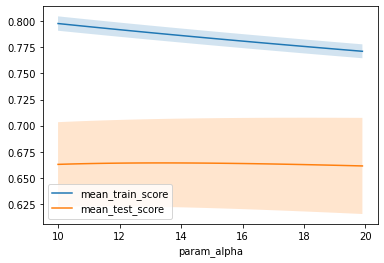

In [40]:
results = pd.DataFrame(grid5.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

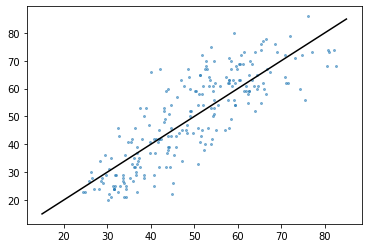

In [41]:
reg = TweedieRegressor(power=1, link='log', alpha = 13.4)
y_woman_pred = cross_val_predict(reg, x_woman_train, y_woman_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_woman_pred, y_woman_train, alpha=.5, s=4)

# Tree - Man

In [42]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
param_grid5 = {'max_depth' : np.arange(1,20,1)}
grid5 = GridSearchCV(clf, param_grid = param_grid5, cv = RepeatedKFold(n_splits=5, n_repeats=3), return_train_score=True)
grid5.fit(x_man_train,y_man_train)
print(f"best parameters: {grid5.best_params_}")
print(f"valid-set score: {grid5.score(x_man_valid, y_man_valid):.3f}")

best parameters: {'max_depth': 1}
valid-set score: 0.505


# Tree - Woman

In [43]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
param_grid5 = {'max_depth' : np.arange(1,20,1)}
grid5 = GridSearchCV(clf, param_grid = param_grid5, cv = RepeatedKFold(n_splits=5, n_repeats=3), return_train_score=True)
grid5.fit(x_woman_train,y_woman_train)
print(f"best parameters: {grid5.best_params_}")
print(f"valid-set score: {grid5.score(x_woman_valid, y_woman_valid):.3f}")

best parameters: {'max_depth': 2}
valid-set score: 0.609


# GradientBoostingRegressor - Man

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
param_grid5 = {'n_estimators' : np.arange(60,80,1)}
grid5 = GridSearchCV(reg, param_grid = param_grid5, 
                     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state = 123), 
                     return_train_score=True)
grid5.fit(x_man_train,y_man_train)
print(f"best parameters: {grid5.best_params_}")
print(f"valid-set score: {grid5.score(x_man_valid, y_man_valid):.3f}")

best parameters: {'n_estimators': 69}
valid-set score: 0.741


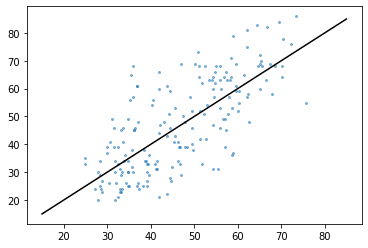

In [45]:
reg = GradientBoostingRegressor(random_state=0, n_estimators = 69)
y_man_pred = cross_val_predict(reg, x_man_train, y_man_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_man_pred, y_man_train, alpha=.5, s=4)

# GradientBoostingRegressor - Woman

In [46]:
reg = GradientBoostingRegressor(random_state=0)
param_grid5 = {'n_estimators' : np.arange(80,90,1)}
grid5 = GridSearchCV(reg, param_grid = param_grid5, 
                     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state = 123), 
                     return_train_score=True)
grid5.fit(x_woman_train,y_woman_train)
print(f"best parameters: {grid5.best_params_}")
print(f"valid-set score: {grid5.score(x_woman_valid, y_woman_valid):.3f}")

best parameters: {'n_estimators': 86}
valid-set score: 0.676


cv의 random_state를 지정하지 않아 최고 정확도를 기록한 6/13 당시의 parameter와 다른 
결과를 도출하게 되었습니다.\
6/13 \
best parameters: {'n_estimators': 81} \
valid-set score: 0.677

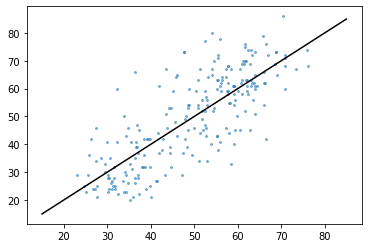

In [47]:
reg = GradientBoostingRegressor(random_state=0, n_estimators = 81)
y_woman_pred = cross_val_predict(reg, x_woman_train, y_woman_train, cv=5)
plt.plot([15, 85], [15, 85], color='k')
plt.scatter(y_woman_pred, y_woman_train, alpha=.5, s=4)

# Test - set

In [48]:
df2 = pd.read_csv("IXI_test.csv")

In [49]:
mant = df2[df2['Sex'].values == 1]
y_mant = mant.Age
X_mant = mant.drop(['ID', 'Age','Sex','ICV'], axis = 1)

womant = df2[df2['Sex'].values == 2]
y_womant = womant.Age
X_womant = womant.drop(['ID', 'Age','Sex','ICV'], axis = 1)

In [50]:
x_mant = std.fit_transform(X_mant)
x_womant = std.fit_transform(X_womant)

In [51]:
regt = linear_model.Lasso(max_iter = 10000, random_state = 1, alpha = 0.33)
regt = regt.fit(x_man_train, y_man_train)
y_man_pred = regt.predict(x_mant)
y_man_pred

array([43.77449364, 66.4270761 , 35.34807744, 40.82482431, 32.99721939,
       62.99381154, 42.00188148, 52.96613992, 39.49024051, 25.23356002,
       23.55858293, 41.00278588, 10.30805897, 38.76743597, 74.00285368,
       68.63151622, 59.69213954, 36.37671465, 38.33020571, 60.01825784,
       44.22814529, 44.48816941, 60.33765513, 72.04649685, 61.9521191 ,
       41.68528488, 62.32091611, 45.26046983, 41.8424121 , 76.51605227,
       44.35029582, 35.15498864, 20.56222093, 39.31692299, 39.94268494,
       51.80902564, 40.31529919, 32.14442611, 60.67543209, 36.91434355,
       48.43458973, 61.1776443 , 43.22852776])

In [52]:
regt = GradientBoostingRegressor(random_state=0, n_estimators = 81).fit(x_woman_train,y_woman_train)
y_woman_pred = regt.predict(x_womant)
y_woman_pred

array([41.45091257, 57.85322351, 43.36407288, 27.13197781, 30.29062811,
       26.72603284, 34.75496175, 57.25480536, 29.85766918, 41.87242415,
       40.38648748, 54.20554869, 71.05260273, 53.10264351, 56.88091508,
       33.46968646, 34.2243513 , 47.40077624, 36.23718914, 45.79131337,
       74.7168235 , 26.73631716, 48.395919  , 25.65834638, 26.98727343,
       60.79860221, 56.59082331, 39.07889831, 63.06525355, 50.61745756,
       48.47701263, 50.06866308, 54.2344726 , 40.35174642, 56.8816663 ,
       55.08967069, 39.12189341, 31.2822403 , 47.90933731, 58.92111795,
       48.67727537, 48.99696589, 65.701356  , 27.0526357 , 67.3561361 ,
       62.41563703, 28.76792704, 47.03571329, 60.32548347, 72.83041061,
       68.84853379, 63.89079679, 57.81809744, 52.68411978, 71.23136458,
       58.72719732, 38.11605909])

In [53]:
test = df2[df2['Sex'].values == 1].to_numpy()
test[:,2] = y_man_pred

In [54]:
test2 = df2[df2['Sex'].values == 2].to_numpy()
test2[:,2] = y_woman_pred

ID의 Values를 남겨두어 excel파일의 오름차순 정렬을 이용하였습니다.

In [55]:
test3 = np.concatenate((test,test2),axis = 0)
test3 = test3[:,(0,2)]

In [56]:
test3 = pd.DataFrame(test3)
test3.to_csv("lXl_test3.csv", mode='w')

In [57]:
df3 = pd.read_csv("COBRE_test_scz.csv")
df3['ICV'] = df3['ICV'] / 1000
mant2 = df3[df3['Sex'].values == 1]
womant2 = df3[df3['Sex'].values == 2]

In [58]:
name = pd.read_excel("anatomical_regions.xlsx")
name = name.drop(['Index', 'Unnamed: 2'], axis = 1)
name = name.iloc[:68,:]

excel 파일에서 ctrl + f 를 통하여 area -> thickness로 수정

In [59]:
womant2 = womant2.reindex(columns=name['Region.1'].values)
i = 0
dic = {}
for i in range(68):
    dic[name['Region.1'][i]] = name['Region'][i]
    i += 1
womant2.rename(columns = dic)

,lbankssts,rbankssts,lcaudalanteriorcingulate,rcaudalanteriorcingulate,lcaudalmiddlefrontal,rcaudalmiddlefrontal,lcuneus,rcuneus,lentorhinal,rentorhinal,...,lsupramarginal,rsupramarginal,lfrontalpole,rfrontalpole,ltemporalpole,rtemporalpole,ltransversetemporal,rtransversetemporal,linsula,rinsula
0,2.637,2.750,2.462,2.660,2.755,2.772,2.037,1.950,3.870,3.671,...,2.546,2.518,2.840,2.949,3.436,3.401,2.155,2.411,2.947,2.908
5,2.491,2.627,2.757,2.667,2.579,2.385,1.795,1.640,3.565,3.713,...,2.425,2.473,2.591,2.607,3.779,4.103,2.083,2.331,2.800,3.117
7,2.409,2.291,2.307,2.536,2.400,2.294,1.762,1.640,3.395,3.137,...,2.353,2.333,2.576,2.609,3.495,3.479,2.011,1.998,2.730,2.701
9,2.599,2.612,2.458,2.748,2.523,2.475,1.771,1.771,3.137,3.338,...,2.518,2.501,2.865,2.866,3.431,3.994,2.502,2.530,2.822,3.007
12,2.514,2.538,2.574,2.316,2.475,2.542,1.775,1.857,3.496,3.236,...,2.571,2.408,2.666,2.834,3.701,3.719,2.372,2.452,3.005,2.848
15,2.444,2.487,2.573,2.488,2.493,2.496,1.717,1.716,3.065,3.514,...,2.448,2.328,2.674,2.273,3.627,3.851,2.261,2.260,2.959,3.155
20,2.548,2.360,2.597,2.405,2.481,2.515,1.940,1.868,3.325,3.166,...,2.356,2.443,2.463,2.975,3.617,3.696,2.635,2.414,2.727,2.829
23,2.272,2.347,2.840,2.628,2.498,2.385,1.713,1.838,3.186,3.195,...,2.255,2.544,2.827,2.517,3.102,2.760,2.246,2.236,2.734,2.864
26,2.759,2.550,2.586,2.337,2.600,2.558,1.927,1.951,3.318,3.390,...,2.777,2.668,2.512,2.744,3.520,3.766,2.166,2.333,2.913,2.876
33,2.291,2.471,2.377,2.438,2.271,2.304,1.619,1.576,3.380,3.274,...,2.356,2.215,2.486,2.448,3.405,3.361,2.224,2.277,2.732,2.568


In [60]:
mant2 = mant2.reindex(columns=name['Region.1'].values)
i = 0
dic = {}
for i in range(68):
    dic[name['Region.1'][i]] = name['Region'][i]
    i += 1
mant2.rename(columns = dic)

,lbankssts,rbankssts,lcaudalanteriorcingulate,rcaudalanteriorcingulate,lcaudalmiddlefrontal,rcaudalmiddlefrontal,lcuneus,rcuneus,lentorhinal,rentorhinal,...,lsupramarginal,rsupramarginal,lfrontalpole,rfrontalpole,ltemporalpole,rtemporalpole,ltransversetemporal,rtransversetemporal,linsula,rinsula
1,2.449,2.606,2.379,2.493,2.553,2.594,1.969,1.984,3.567,3.151,...,2.482,2.476,2.721,2.730,3.630,3.519,2.095,2.147,2.976,2.737
2,2.516,2.347,2.593,2.639,2.586,2.406,1.875,1.781,3.516,3.582,...,2.531,2.483,2.769,2.627,3.445,3.653,2.541,2.435,2.800,3.018
3,2.458,2.792,2.695,2.669,2.654,2.549,1.779,1.749,3.270,3.382,...,2.478,2.544,2.555,2.616,4.137,3.925,2.305,2.018,3.137,3.217
4,2.422,2.716,2.531,2.307,2.515,2.488,1.710,1.842,3.750,3.650,...,2.459,2.464,2.335,2.878,3.385,3.598,2.308,2.330,2.977,2.808
6,2.361,2.473,2.168,2.316,2.359,2.429,1.836,1.874,3.303,3.195,...,2.397,2.419,2.471,2.445,3.357,3.750,2.430,2.417,2.740,2.654
8,2.579,2.681,2.607,2.536,2.638,2.654,1.896,1.975,3.554,3.611,...,2.666,2.648,2.717,2.554,3.513,3.674,2.465,2.486,2.925,3.087
10,2.397,2.527,2.464,2.599,2.314,2.228,1.501,1.429,3.367,3.601,...,2.366,2.348,2.428,2.312,3.541,3.805,2.195,2.270,2.795,2.887
11,2.642,2.788,2.767,2.692,2.577,2.482,1.731,1.820,3.307,3.454,...,2.565,2.615,2.765,2.662,3.571,3.527,2.253,2.466,3.024,2.935
13,2.570,2.508,2.654,2.439,2.502,2.586,1.977,1.941,3.639,3.465,...,2.486,2.565,2.701,2.511,3.494,3.292,2.635,2.397,2.760,2.703
14,2.491,2.557,2.309,1.994,2.183,1.910,1.914,1.833,2.676,2.739,...,2.287,2.318,2.677,2.447,3.859,2.903,1.876,2.118,2.576,2.415


In [61]:
x_mant2 = std.fit_transform(mant2)
x_womant2 = std.fit_transform(womant2)

In [62]:
regt = linear_model.Lasso(max_iter = 10000, random_state = 1, alpha = 0.33).fit(x_man_train,y_man_train)
y_man_pred2 = regt.predict(x_mant2)
y_man_pred2

array([47.17121326, 44.42591092, 47.12011793, 41.26000663, 50.97386254,
       40.24662684, 58.90064757, 51.58184477, 41.64999509, 53.20059464,
       40.49479267, 45.49315406, 52.00236416, 43.67205627, 42.13581776,
       44.14535957, 47.66117686, 61.56812534, 54.81978482, 30.77227693,
       25.70655184, 40.36589742, 41.75320268, 47.72733177, 53.65463483,
       55.94513938, 72.21393275, 46.36943712, 42.90862005, 44.07257058,
       44.20535595, 34.97908125, 15.00068545, 61.58671399, 60.43931408,
       61.56074232, 43.55936215, 56.97081127, 26.949406  , 44.03640301,
       32.23218477, 56.07381873, 54.88039618, 31.30768773, 66.28754515,
       46.79129069, 58.9841543 , 43.94679344, 38.3368111 , 52.20766286,
       51.99443656, 50.85361315, 39.71161608, 44.69023497, 48.94447825,
       46.38555566, 54.508462  , 16.79721739])

In [63]:
regt = GradientBoostingRegressor(random_state=0, n_estimators = 81).fit(x_woman_train,y_woman_train)
y_woman_pred2 = regt.predict(x_womant2)
y_woman_pred2

array([30.98946792, 52.08337356, 65.87626915, 36.80386523, 29.6375787 ,
       62.05969441, 37.95330078, 55.96562261, 47.31021014, 62.86930431,
       40.89442723, 42.35636161, 50.25205277, 56.11257044])

In [64]:
cobre = df3[df3['Sex'].values == 1]
cobre = cobre.iloc[:,:2]
cobre = cobre.to_numpy()
cobre[:,1] = y_man_pred2

In [65]:
cobre2 = df3[df3['Sex'].values == 2]
cobre2 = cobre2.iloc[:,:2]
cobre2 = cobre2.to_numpy()
cobre2[:,1] = y_woman_pred2

ID의 Values를 남겨두어 excel파일의 오름차순 정렬을 이용하였습니다.

In [66]:
cobre3 = np.concatenate((cobre,cobre2),axis = 0)
cobre3 = pd.DataFrame(cobre3)
cobre3

,0,1
0,40001.0,47.171213
1,40002.0,44.425911
2,40003.0,47.120118
3,40004.0,41.260007
4,40006.0,50.973863
...,...,...
67,40064.0,62.869304
68,40071.0,40.894427
69,40088.0,42.356362
70,40097.0,50.252053


In [67]:
cobre3.to_csv("cobre_test0.csv", mode='w')